In [14]:
# tool
import pandas as pd
import matplotlib.pyplot as plt
# data
from skforecast.datasets import load_demo_dataset
# feature
from skforecast.preprocessing import RollingFeatures
# model
from lightgbm import LGBMRegressor
from skforecast.recursive import (
    ForecasterRecursive,
    ForecasterRecursiveMultiSeries,
)
# validate
from sklearn.metrics import mean_squared_error

# tune
from skforecast.model_selection import (
    TimeSeriesFold, 
    backtesting_forecaster,
    grid_search_forecaster,
)

# data

In [3]:
data = load_demo_dataset()
print(data.head(), "\n")
print(data.shape, "\n")
print(data.tail(), "\n")

datetime
1991-07-01    0.429795
1991-08-01    0.400906
1991-09-01    0.432159
1991-10-01    0.492543
1991-11-01    0.502369
Freq: MS, Name: y, dtype: float64 

(204,) 

datetime
2008-02-01    0.761822
2008-03-01    0.649435
2008-04-01    0.827887
2008-05-01    0.816255
2008-06-01    0.762137
Freq: MS, Name: y, dtype: float64 



# data split

In [4]:
train_end = "2005-06-01 23:59:00"

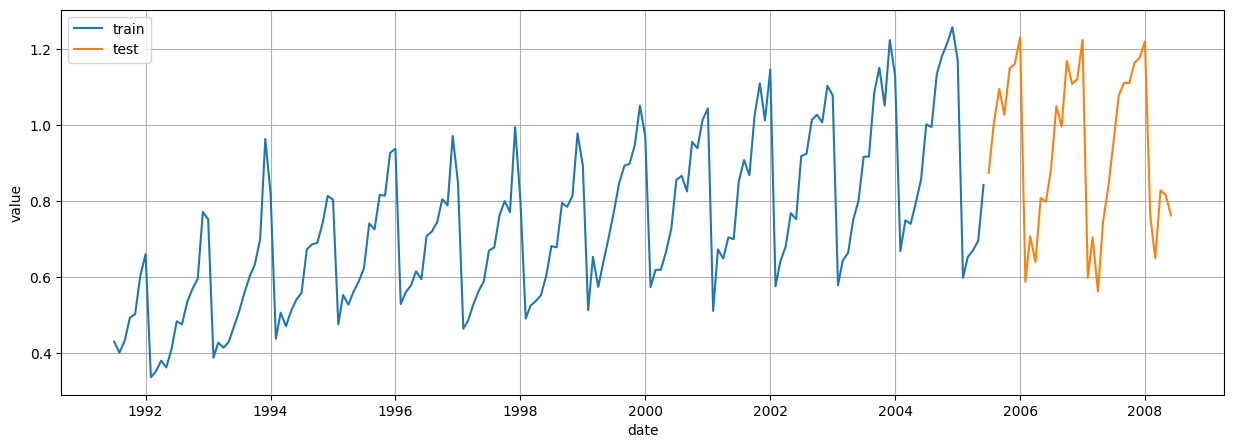

In [13]:
fig = plt.figure(figsize=(15, 5))
plt.plot(data.loc[:train_end], label = "train")
plt.plot(data.loc[train_end:], label = "test")
plt.legend()
plt.xlabel("date")
plt.ylabel("value")
plt.grid()
plt.show()

# model training

In [16]:
fcst = ForecasterRecursive(
    regressor=LGBMRegressor(random_state = 123, verbose = -1),
    lags=15,
    window_features=RollingFeatures(stats=["mean"], window_sizes=10),
    transformer_y=None,
    transformer_exog=None,
    weight_func=None,
    differentiation=None,
    fit_kwargs=None,
    binner_kwargs=None,
    forecaster_id=None,
)
fcst.fit(y = data.loc[:train_end])
fcst

=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Window features: ['roll_mean_10'] 
Window size: 15 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-12-23 22:02:13 
Last fit date: 2024-12-23 22:02:13 
Skforecast version: 0.14.0 
Python version: 3.11.9 
Forecaster id: None

# model predict

In [18]:
preds = fcst.predict(steps=len(data.loc[train_end:]))
preds

2005-07-01    1.026507
2005-08-01    1.042429
2005-09-01    1.116730
2005-10-01    1.162179
2005-11-01    1.143455
2005-12-01    1.160991
2006-01-01    1.126347
2006-02-01    0.685447
2006-03-01    0.667809
2006-04-01    0.691714
2006-05-01    0.697669
2006-06-01    0.860555
2006-07-01    1.035387
2006-08-01    1.097396
2006-09-01    1.136739
2006-10-01    1.170774
2006-11-01    1.145629
2006-12-01    1.159493
2007-01-01    1.126674
2007-02-01    0.723829
2007-03-01    0.672419
2007-04-01    0.695156
2007-05-01    0.692553
2007-06-01    0.871146
2007-07-01    1.031689
2007-08-01    1.101709
2007-09-01    1.136739
2007-10-01    1.170774
2007-11-01    1.159630
2007-12-01    1.159294
2008-01-01    1.126674
2008-02-01    0.722142
2008-03-01    0.678300
2008-04-01    0.713316
2008-05-01    0.716118
2008-06-01    0.877843
Freq: MS, Name: pred, dtype: float64

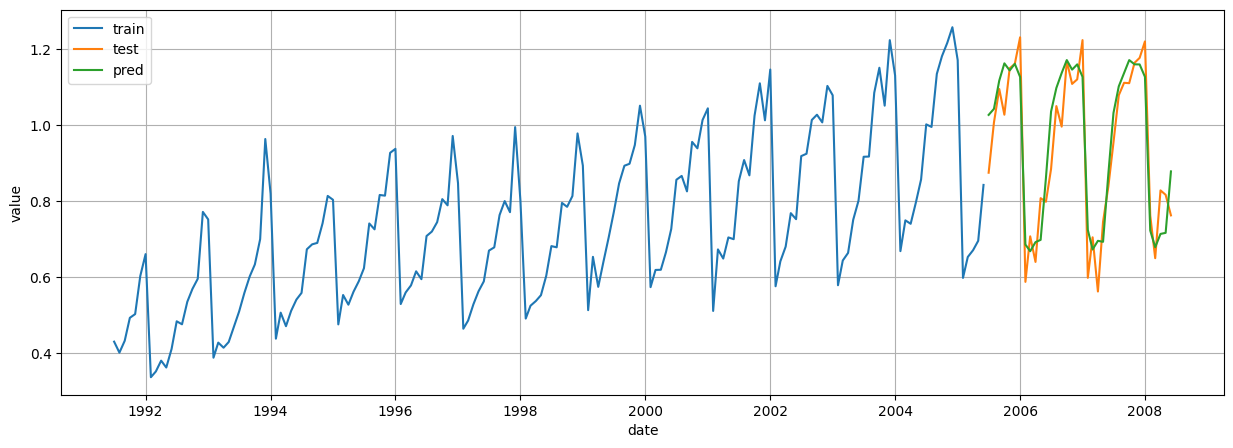

In [19]:
fig = plt.figure(figsize = (15, 5))
plt.plot(data.loc[:train_end], label = "train")
plt.plot(data.loc[train_end:], label = "test")
plt.plot(preds, label = "pred")
plt.legend()
plt.xlabel("date")
plt.ylabel("value")
plt.grid()
plt.show()

In [21]:
train_mse = mean_squared_error(
    y_true=data.loc[train_end:],
    y_pred=preds,
)
print(f"Test error (mse): {train_mse})

Test error (mse): 0.006632513357651682


In [23]:
train_error_mse = mean_squared_error(
    y_true = data.loc[train_end:],
    y_pred = preds,
)
print(f"Test error (mse): {train_error_mse}")

Test error (mse): 0.006632513357651682


# model validation

In [26]:
cv = TimeSeriesFold(
    steps=10,
    initial_train_size=len(data.loc[:train_end]),
    refit=True,
    fixed_train_size=True,
)
metric, preds_backtest = backtesting_forecaster(
    forecaster=fcst,
    y = data,
    cv = cv,
    metric="mean_squared_error",
    n_jobs="auto",
    verbose=True,
    show_progress=True,
)
print(f"Backtest error: {metric}")

Information of folds
--------------------
Number of observations used for initial training: 168
Number of observations used for backtesting: 36
    Number of folds: 4
    Number skipped folds: 0 
    Number of steps per fold: 10
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 6 observations.

Fold: 0
    Training:   1991-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=168)
    Validation: 2005-07-01 00:00:00 -- 2006-04-01 00:00:00  (n=10)
Fold: 1
    Training:   1992-05-01 00:00:00 -- 2006-04-01 00:00:00  (n=168)
    Validation: 2006-05-01 00:00:00 -- 2007-02-01 00:00:00  (n=10)
Fold: 2
    Training:   1993-03-01 00:00:00 -- 2007-02-01 00:00:00  (n=168)
    Validation: 2007-03-01 00:00:00 -- 2007-12-01 00:00:00  (n=10)
Fold: 3
    Training:   1994-01-01 00:00:00 -- 2007-12-01 00:00:00  (n=168)
    Validation: 2008-01-01 00:00:00 -- 2008-06-01 00:00:00  (n=6)



  0%|          | 0/4 [00:00<?, ?it/s]

Backtest error:    mean_squared_error
0            0.005915


# Hypterparameter tuning

## grid search

In [28]:
# regressor hypterparamters
param_grid = {
    "n_estimators": [5, 100],
    "max_depth": [5, 10, 15],
}

# lags
lags_grid = [
    3, 
    10, 
    [1, 2, 3, 20]
]

# folds
cv = TimeSeriesFold(
    steps=10,
    initial_train_size=len(data.loc[:train_end]),
    refit=False,
    fixed_train_size=True,
)

results_grid = grid_search_forecaster(
    forecaster=fcst,
    y=data,
    param_grid=param_grid,
    lags_grid=lags_grid,
    cv=cv,
    metric="mean_squared_error",
    return_best=True,
    n_jobs="auto",
    verbose=False,
    show_progress=True,
)

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 0.018772266038051866


In [29]:
results_grid

,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.018772,5,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 15, 'n_estimators': 100}",0.018898,15,100
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.018898,10,100
3,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 10, 'n_estimators': 100}",0.040312,10,100
4,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 15, 'n_estimators': 100}",0.040312,15,100
5,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.040562,5,100
6,"[1, 2, 3, 20]","[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.042146,5,100
7,"[1, 2, 3, 20]","[1, 2, 3, 20]","{'max_depth': 15, 'n_estimators': 100}",0.042147,15,100
8,"[1, 2, 3, 20]","[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.042147,10,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 15, 'n_estimators': 5}",0.051533,15,5


In [30]:
fcst

=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Window features: ['roll_mean_10'] 
Window size: 10 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2008-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-12-23 22:02:13 
Last fit date: 2024-12-23 22:49:37 
Skforecast version: 0.14.0 
Python version: 3.11.9 
Forecaster id: None